Smoothening:
- Gaussian/Median blur
- Bilateal filter

Sharpening?

Detection:
- Canny edge
- Line detect
- Derivative detect
- Binary + contour
- Corner detect

Area of interest?

In [1]:
### Import library
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks
from scipy.stats import linregress
import math
import pwlf # piecewise linear fit
import sklearn # scikit learn: linear fit and clustering
from sklearn.cluster import DBSCAN, OPTICS # clustering options
from sklearn.mixture import GaussianMixture # clustering options

Image size is  (2048, 2048, 3)


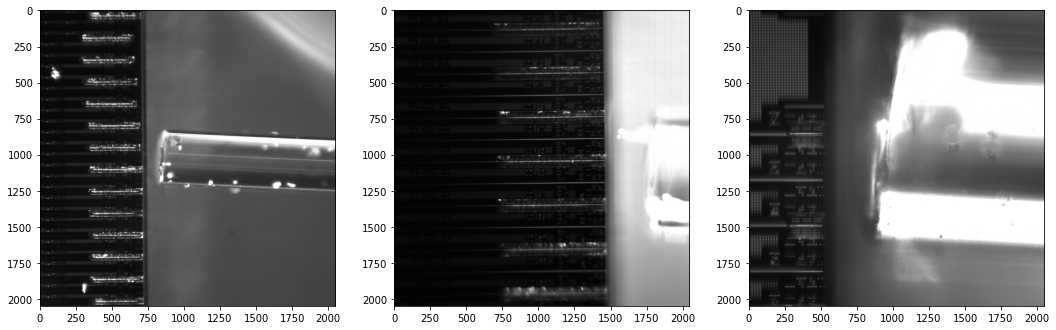

In [2]:
### Show image
img10 = cv.imread('Photos/Photo_Fiber_Obj_10X.tif')
img20 = cv.imread('Photos/Photo_Fiber_Obj_20X.tif')
img50 = cv.imread('Photos/Photo_Fiber_Obj_50X.tif')
print("Image size is ", img10.shape)
plt.figure(figsize=[18,6])
plt.subplot(131); plt.imshow(img10)
plt.subplot(132); plt.imshow(img20)
plt.subplot(133); plt.imshow(img50)

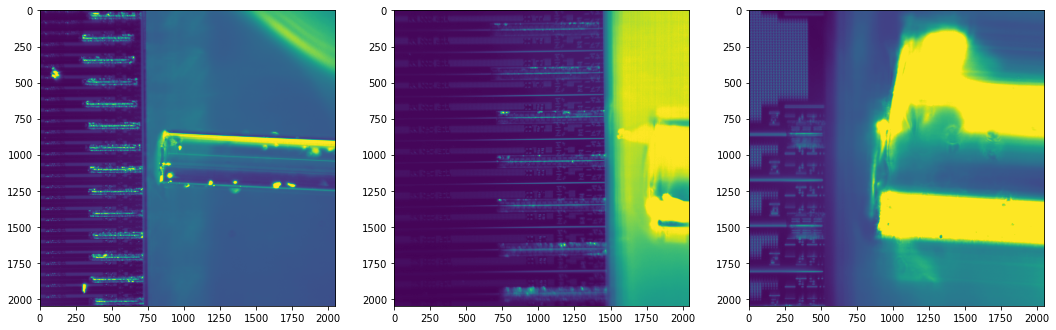

In [3]:
### Gray conversion
imgs = [img10, img20, img50]
grays = []
hsv = []
plt.figure(figsize=[18,6])
for i in range(0,3):
    grays.append(cv.cvtColor(imgs[i], cv.COLOR_BGR2GRAY))
    hsv.append(cv.cvtColor(imgs[i], cv.COLOR_BGR2HSV))
    plt.subplot(131+i)
    plt.imshow(grays[i])

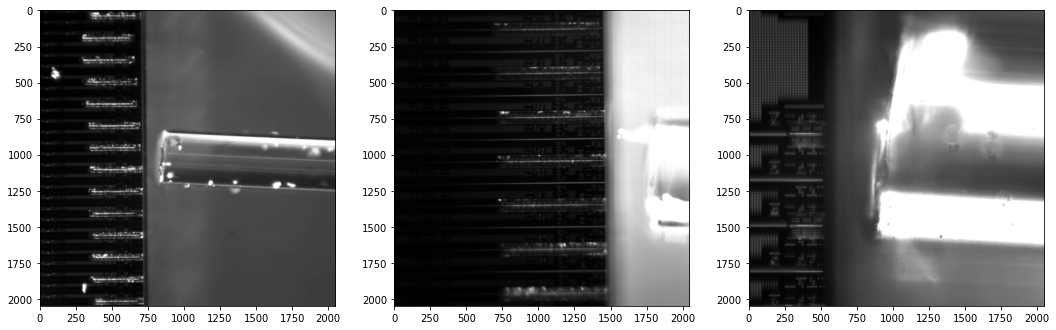

In [4]:
### Smoothening
# compare between Median blur and Gaussian blur
# identify noise patch? further cleaning?

plt.figure(figsize=[18,6])
blurs = []
for i in range(0,3):
    blurs.append(cv.GaussianBlur(grays[i],(0,0),2)) # (0,0): todo
#     blurs.append(cv.GaussianBlur(grays[i],(7,7),11))
#     blurs.append(cv.medianBlur(grays[i],51))
    plt.subplot(131+i)
    plt.imshow(blurs[i], cmap='gray')


[   0.          731.38430984  750.26190031 2047.        ]
[   0.         1432.91694753 1567.34822138 2047.        ]
[   0.          584.56341914 1118.66726727 2047.        ]


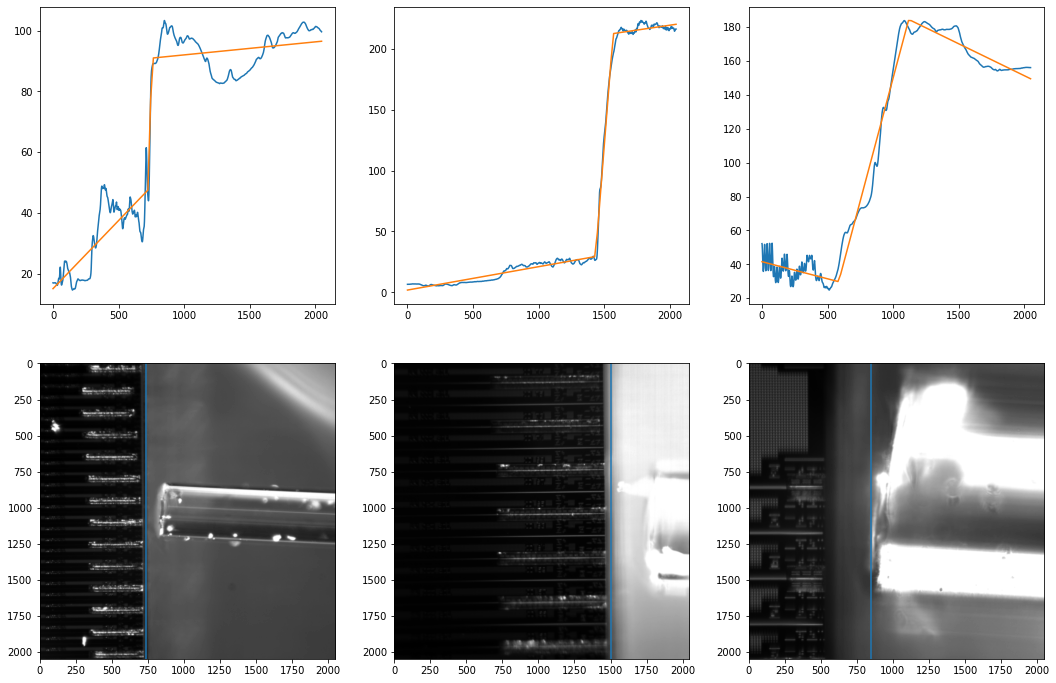

In [5]:
### Image segmentation into chip and fiber
### Auto-segmentation vs manual-segmentation?

plt.figure(figsize=[18,12])
segs = []
    
for i in range(0,3):
    plt.subplot(231+i)
    x = np.arange(0,blurs[i].shape[1]) # width (horizontal) of the image
    y = np.array(list(np.mean(blurs[i][:,j]) for j in range(0,blurs[i].shape[1]))) # todo
    plt.plot(x, y)

    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    segs.append(my_pwlf.fit(3)) # 3 is the number of segments
    x_hat = np.linspace(x.min(), x.max(), 100) # to plot the orange line
    y_hat = my_pwlf.predict(x_hat)
    plt.plot(x_hat, y_hat, '-')
    print(segs[i])

for i in range(0,3):
    plt.subplot(234+i)
    plt.imshow(blurs[i], cmap='gray')
    plt.axvline(x = int((segs[i][1] + segs[i][2])/2))

plt.show()

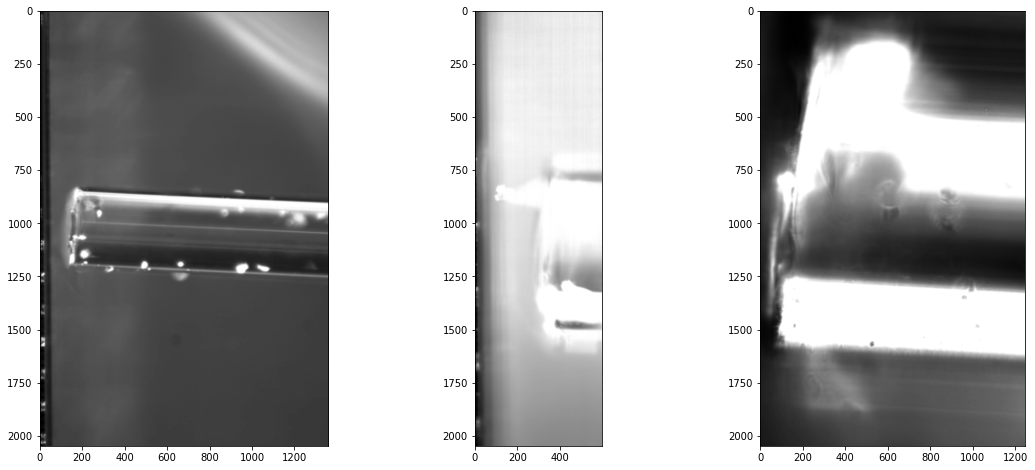

In [6]:
# To reload the py files whenever py files are modified
%load_ext autoreload
%autoreload
from img_processing import *
f = []
plt.figure(figsize=[18,8])
for i in range(0,3):
    f.append(img_separator(blurs[i])[1])
    plt.subplot(131+i)
    plt.imshow(f[i], cmap='gray')

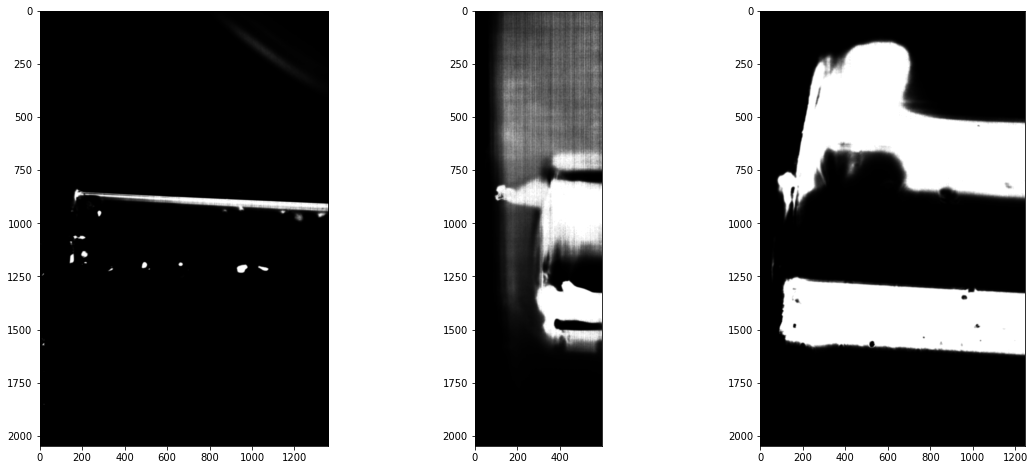

In [7]:
### Contrast enhancer
### 2 methods: alpha*image + beta or gamma power

alpha = 1.4
beta = -100

# When γ<1, the original dark regions will be brighter and 
# the histogram will be shifted to the right whereas it will be the opposite with γ>1.
gamma = 14
# gamma = 0.5
plt.figure(figsize=[18,8])
lookUpTable = np.empty((1,256), np.uint8)

for i in range(256):
    lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)

pf = []
for i in range(0,3):
    image = f[i]
    
    new_image = cv.LUT(image, lookUpTable) # LUT is look up table
#     new_image = np.clip(alpha*image + beta, 0, 255)
    
    pf.append(new_image)
    plt.subplot(131+i)
    plt.imshow(pf[i], cmap='gray')

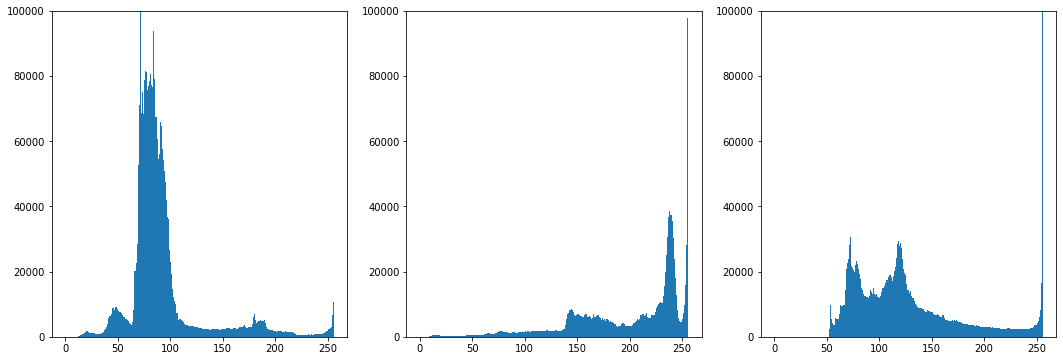

In [8]:
### Image histogram
plt.figure(figsize=[18,6])
for i in range(0,3):
    plt.subplot(131+i)
    plt.hist(f[i].ravel(),256,[0,256])
    plt.ylim([0,1e5])
plt.show()

41 124
111 255
66 198


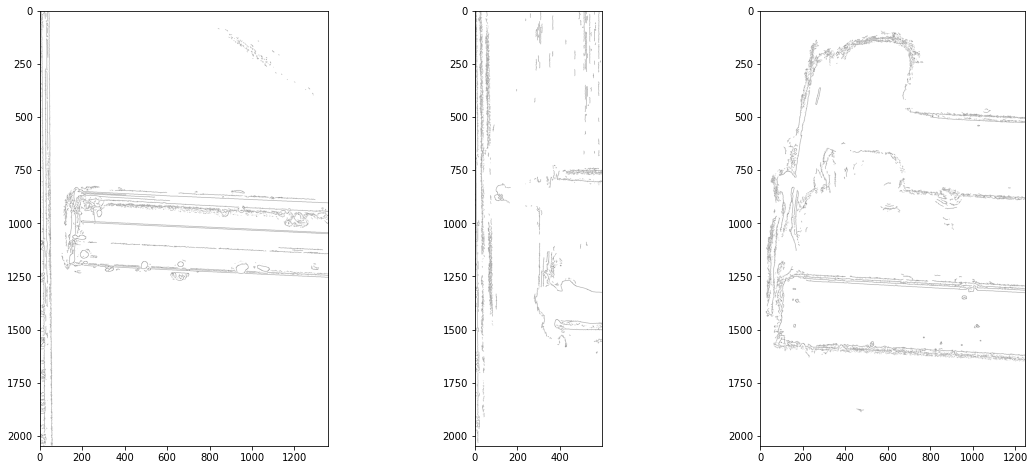

In [9]:
### Canny edge
# apply optimal Canny edge detection using the computed median

y_pos = 1000
plt.figure(figsize=[18,8])
cannys = []
for i in range(0,3):
    v = np.median(f[i])
    sigma = 0.5
    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))
    print(lower_thresh,upper_thresh)
    cannys.append(cv.Canny(f[i], 10, 20))
    plt.subplot(131+i)
    plt.imshow(cv.bitwise_not(cannys[i]), cmap='gray')
#     plt.axhline(y=y_pos)
#     plt.subplot(234+i)
#     peaks, properties = find_peaks(cannys[i][pos,:], prominence=15)
#     plt.plot(peaks, cannys[i][pos,:][peaks], "x", c="red")
#     plt.plot(range(0,cannys[i].shape[1]), cannys[i][y_pos,:], label='Canny edge')
#     plt.plot(range(0,f[i].shape[1]), f[i][y_pos,:], label='Orginal')
#     plt.xlim([0,2048])
#     plt.legend()
    

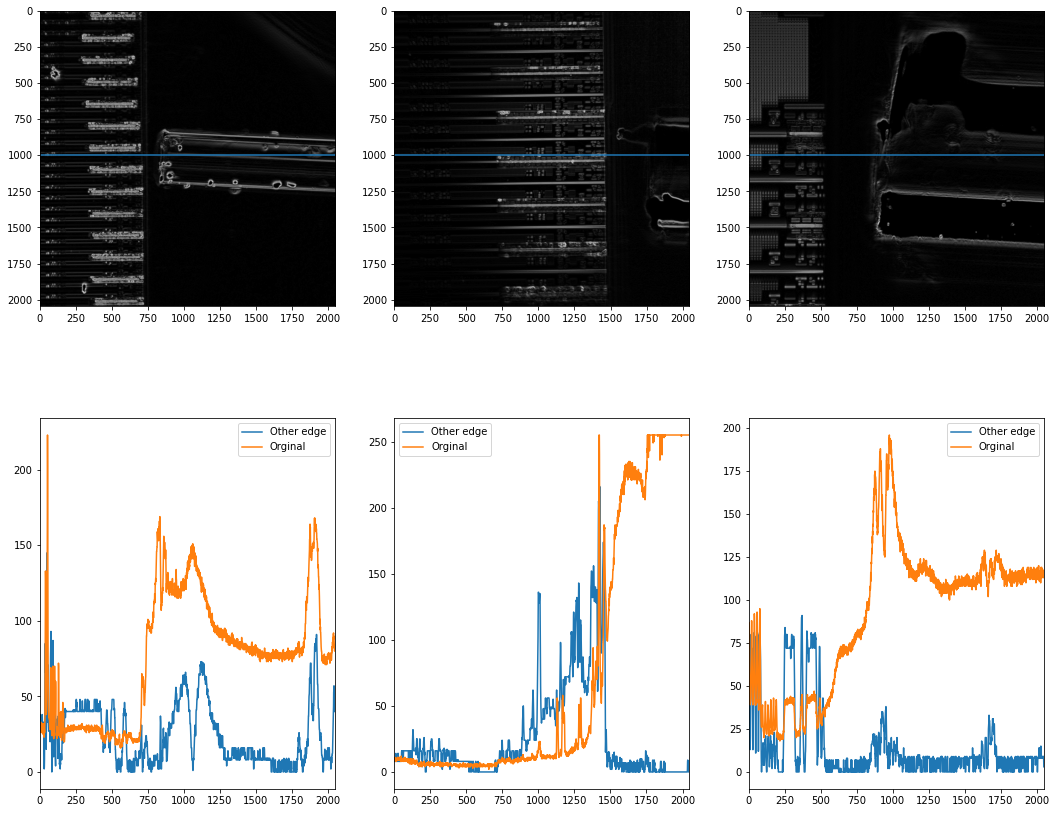

In [10]:
### Other edge detection methods
scale = 1
delta = 0
ddepth = cv.CV_16S
plt.figure(figsize=[18,15])
others = []
for i in range(0,3):
    grad_x = cv.Sobel(blurs[i], ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    # Gradient-Y
    grad_y = cv.Scharr(blurs[i],ddepth,0,1)
#     grad_y = cv.Sobel(blurs[i], ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    
    
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    others.append(grad)
    plt.subplot(231+i)
    plt.imshow(others[i], cmap='gray')
    plt.axhline(y=y_pos)
    plt.subplot(234+i)
#     peaks, properties = find_peaks(cannys[i][pos,:], prominence=15)
#     plt.plot(peaks, cannys[i][pos,:][peaks], "x", c="red")
    plt.plot(range(0,others[i].shape[1]), others[i][y_pos,:], label='Other edge')
    plt.plot(range(0,grays[i].shape[1]), grays[i][y_pos,:], label='Orginal')
    plt.xlim([0,2048])
    plt.legend()

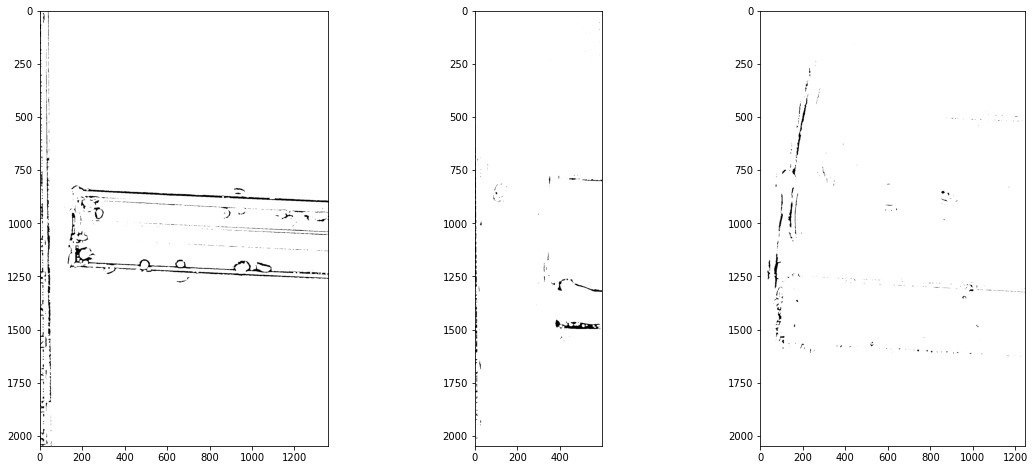

In [11]:
### Adaptive binary

y_pos = 1000
adaps = []
for i in range(0,3):
    adaps.append(cv.bitwise_not(cv.adaptiveThreshold(f[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv.THRESH_BINARY,21,2)))

plt.figure(figsize=[18,8])
for i in range(0,3):
    plt.subplot(131+i)
    erode = cv.erode(adaps[i], np.ones((3,3)), iterations=2)
    plt.imshow(cv.bitwise_not(erode), cmap='gray')
#     plt.axhline(y=y_pos)
#     plt.subplot(234+i)
#     peaks, properties = find_peaks(cannys[i][pos,:], prominence=15)
#     plt.plot(peaks, cannys[i][pos,:][peaks], "x", c="red")
#     plt.plot(range(0,adaps[i].shape[1]), adaps[i][y_pos,:], label='Adaptive threshold')
#     plt.plot(range(0,f[i].shape[1]), f[i][y_pos,:], label='Orginal')
#     plt.xlim([0,2048])
#     plt.legend()


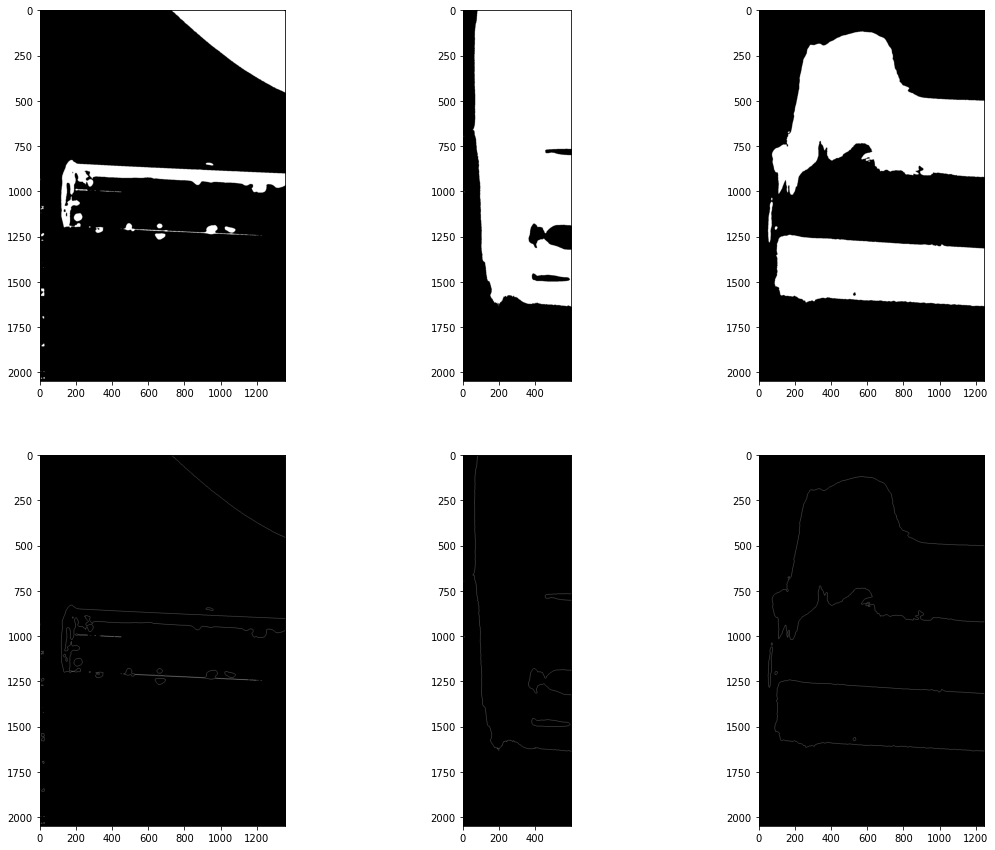

In [12]:
### Basic binary and contour
### Otsu will determine the threshold automatically.

y_pos = 1000

otsu = []
for i in range(0,3):
    otsu.append(cv.threshold(f[i], 127, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1])
    
plt.figure(figsize=[18,15])
blanks = []
for i in range(0,3):
    plt.subplot(231+i)
    plt.imshow(otsu[i], cmap='gray')

    blank = np.zeros(otsu[i].shape, dtype = 'uint8') # black blank image
    contours, hierarchies = cv.findContours(otsu[i], cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE) # find contour of binary images
    cv.drawContours(blank, contours, -1, (255,255,255), 1)
    blanks.append(blank)
#     print(len(contours))
    plt.subplot(234+i)
    plt.imshow(blank, cmap='gray')


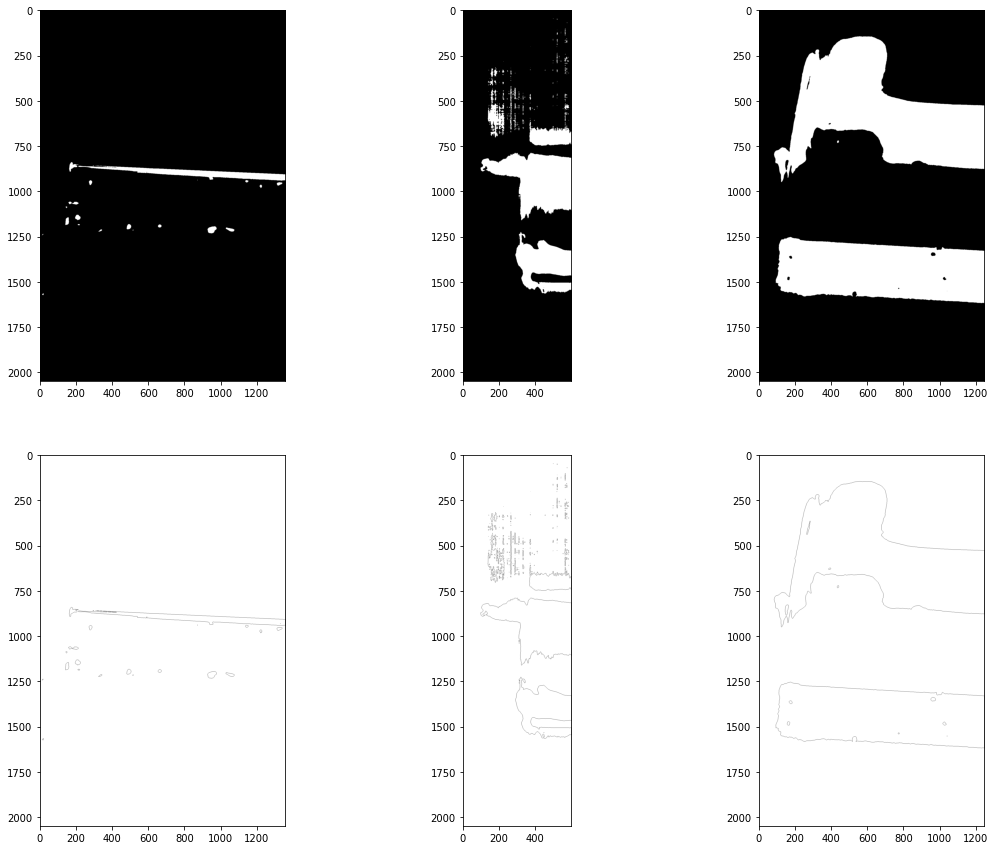

In [13]:
### Basic binary and contour
### Otsu will determine the threshold automatically.
### To apply method on contrast enhanced images.

y_pos = 1000

potsu = []
for i in range(0,3):
    potsu.append(cv.threshold(pf[i], 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1])
    
plt.figure(figsize=[18,15])
pblanks = []
for i in range(0,3):
    plt.subplot(231+i)
    plt.imshow(potsu[i], cmap='gray')

    blank = np.zeros(potsu[i].shape, dtype = 'uint8')
    contours, hierarchies = cv.findContours(potsu[i], cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(blank, contours, -1, (255,255,255), 1)
    pblanks.append(blank)
#     print(len(contours))
    plt.subplot(234+i)
    plt.imshow(cv.bitwise_not(blank), cmap='gray')


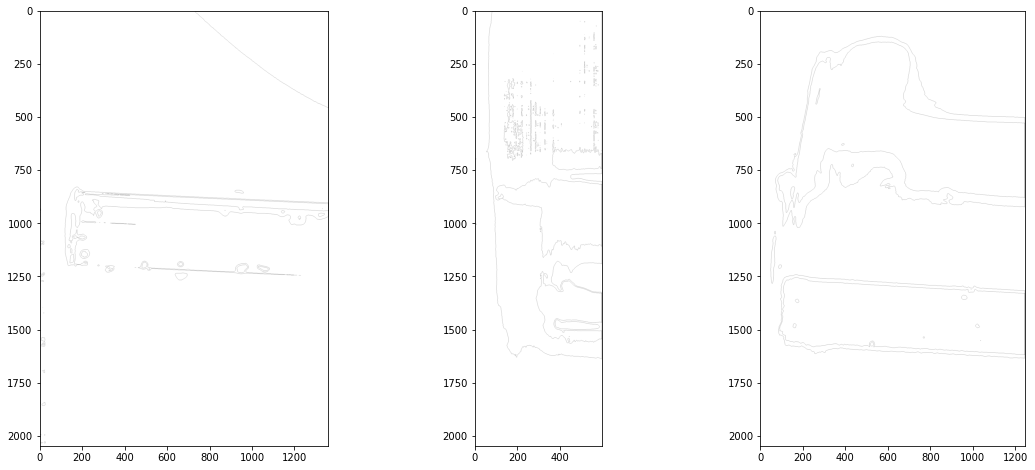

In [14]:









### Comparison of contours of between original and contrast enhanced images
plt.figure(figsize=[18,8])
for i in range(0,3):
    plt.subplot(131+i)
    new_img = cv.addWeighted(blanks[i], 0.5, pblanks[i], 0.5, 0.0)
    plt.imshow(cv.bitwise_not(new_img), cmap='gray')


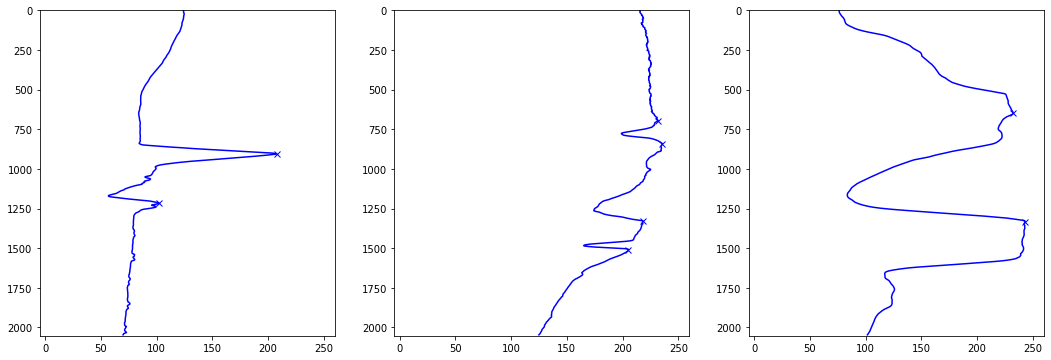

[array([ 904, 1217], dtype=int64), array([ 695,  842, 1330, 1509], dtype=int64), array([ 645, 1332], dtype=int64)]


In [15]:
### Vertical profiling to calculate the background grayscale intensity
plt.figure(figsize=[18,6])

peaks = []
for i in range(0,3):
    plt.subplot(131+i)
    y = np.arange(0,f[i].shape[0])
    x = np.array(list(np.mean(f[i][j,:]) for j in range(0,f[i].shape[0])))
    plt.plot(x, y, c='blue')
    plt.xlim([-5,260])
    plt.ylim([-5,2053])
    plt.gca().invert_yaxis()
    peaks.append(find_peaks(x, prominence=15)[0])
    plt.plot(x[peaks[i]], peaks[i], "x", c="blue")
# for i in range(0,3):
#     plt.subplot(131+i)
#     y = np.arange(0,pf[i].shape[0])
#     x = np.array(list(np.mean(pf[i][j,:]) for j in range(0,pf[i].shape[0])))
#     plt.plot(x, y, c='red')
#     plt.xlim([-5,260])
#     plt.ylim([-5,2053])
#     plt.gca().invert_yaxis()
#     peaks, properties = find_peaks(x, prominence=20)
#     plt.plot(x[peaks], peaks, "x", c="red")
plt.show()
print(peaks)

In [16]:
### Background and fiber area grayscale median
for i in range(0,3):
    first_peak = peaks[i][0]
    last_peak = peaks[i][len(peaks[i])-1]
    # margin of 50 pixels
    background= np.concatenate((f[i][:first_peak-50,:].ravel(),f[i][last_peak+50:,:].ravel()))
    bg_median = np.median(background)
    fiber_median = np.median(f[i][first_peak+50:last_peak-50,:].ravel())
    print(first_peak, last_peak, bg_median, fiber_median)

904 1217 82.0 84.0
695 1509 207.0 225.0
645 1332 124.0 130.0


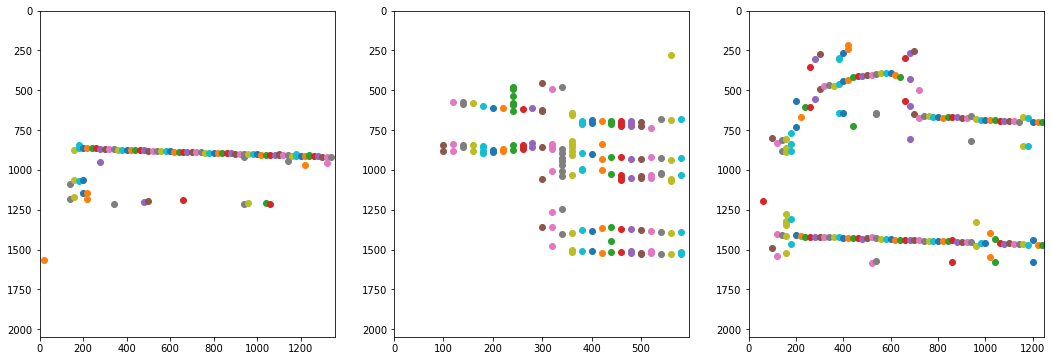

In [17]:
### Get peaks  by sampling to obtain straight lines to calculate the angle 
plt.figure(figsize=[18,6])

step = 20
data = []
for i in range(0,3):
    plt.subplot(131+i)
    x_data = []
    y_data = []
    for j in range(0,pf[i].shape[1],step):
#         if j < abs(step):
#             break
#         y = np.arange(0,pf[i].shape[0])
#         x = np.array(list(np.mean(pf[i][k,j+step:j]) for k in np.arange(0,pf[i].shape[0])))
        x = pf[i][:,j]
        peaks, _ = find_peaks(x, prominence=50)
#         plt.scatter([j+step/2]*len(peaks), peaks)
#         x_data.append([j+step/2]*len(peaks))
        plt.scatter([j]*len(peaks), peaks)
        x_data.append([j]*len(peaks))
        y_data.append(peaks)
#         print(peaks)
        plt.ylim([0,pf[i].shape[0]])
        plt.xlim([0,pf[i].shape[1]])
        plt.gca().invert_yaxis()
    data.append([[item for sublist in x_data for item in sublist],
                 [item for sublist in y_data for item in sublist]])
plt.show()

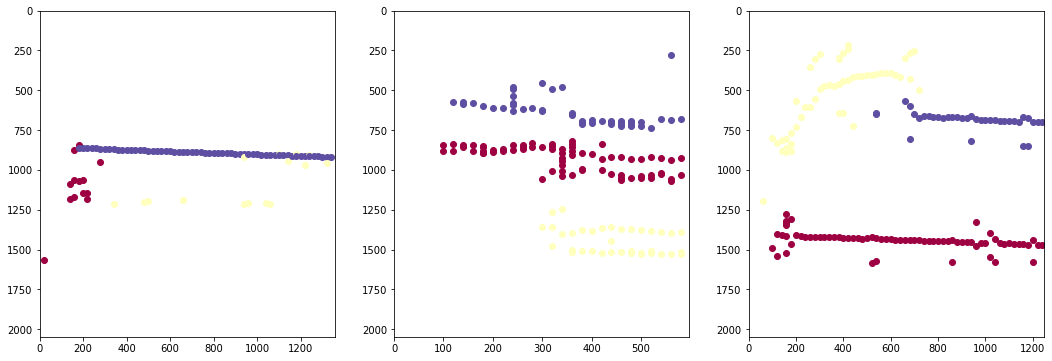

In [18]:
### Clustering those points by Gaussian Mixture to do linear fitting

data_labels = []
plt.figure(figsize=[18,6])
for i in range(0,3):
    plt.subplot(131+i)
#     clustering = DBSCAN(eps=100, min_samples=10, metric='euclidean', 
#                         metric_params=None, algorithm='auto', 
#                         leaf_size=30, p=None, n_jobs=None)
#     clustering = OPTICS(min_samples=20, xi=0.2)
    clustering = GaussianMixture(n_components=3) # n_components is the number of clusters
    X = np.array([[k,j] for k,j in zip(data[i][0], data[i][1])])
    labels = clustering.fit_predict(X)
    unique_labels = list(set(labels))
    data_labels.append(labels)
#     print(unique_labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    cmap = {}
    for j in range(0,len(unique_labels)):
        cmap[unique_labels[j]] = colors[j]
#     print(cmap)
    for k in range(0,len(X)):
        plt.plot(X[k,0],X[k,1],marker='o',c=cmap[labels[k]])
    plt.ylim([0,pf[i].shape[0]])
    plt.xlim([0,pf[i].shape[1]])
    plt.gca().invert_yaxis()
    

0 -1.896888260254597 1433.1513437057993 -0.6416844697301436 0.018069434389717864 0.6835991885653807
1 -0.31829128674817025 1376.1515312589443 -0.6710355470314977 0.006168936912778325 0.09753823152328038
2 0.048842781998831096 853.6082992402104 0.9982134333669739 1.8779728055256546e-71 0.00038723098524309405
0 0.37998501325750283 794.9968745596843 0.6608495260150166 2.66418643866904e-10 0.051579392532094884
1 0.3635351639236914 1279.6967739119048 0.38078437417873295 0.021954583520059728 0.15139507031166244
2 0.31895923922649977 516.9760313925125 0.436415084248392 0.0024288396100637676 0.09913539797274588
0 0.06431716889921224 1402.5691460242545 0.39473430199033777 0.0006007427102601746 0.017893356046640684
1 -0.8949302585536549 861.6662568040437 -0.7249166481693544 1.7974011803864194e-09 0.12148405765173369
2 0.12676285502356857 570.3437178474865 0.4383174069099551 0.007497537254194045 0.0445796532487621
[['2.8'], ['20.81'], ['3.68']]


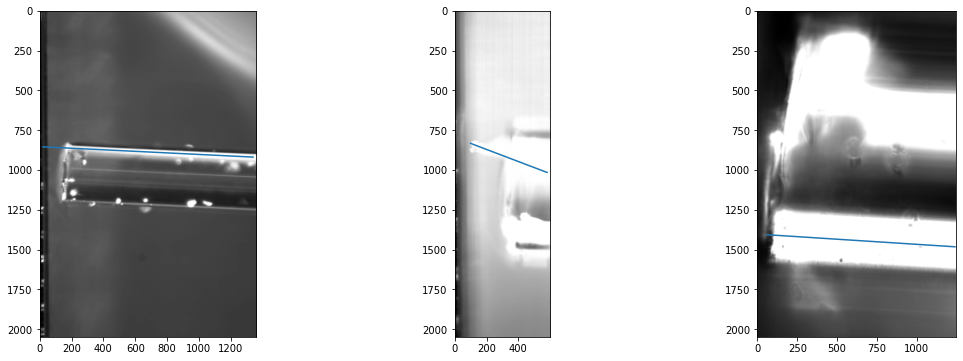

In [19]:
### Angle calculation: select lines with minimum std dev
### To fit robust? Neglect outliers?

plt.figure(figsize=[18,6])
degs = []
for i in range(0,3):
    X = np.array([[i,j] for i,j in zip(data[i][0], data[i][1])])
    min_std = 1.0
    max_r = 0.0
    for j in set(data_labels[i]):
        xy = X[data_labels[i] == j]
        if len(xy) > 5:
            slope, intercept, r_value, p_value, std_err = linregress(xy[:,0], xy[:,1]) # fiting a linear line
            print(j, slope, intercept, r_value, p_value, std_err)
            if (std_err <= min_std) & (r_value > 0):
                min_std = std_err
                max_r = r_value
                selected_label = j
                selected_slope = slope
                selected_intercept = intercept
    
    degs.append([np.format_float_positional(np.arctan(selected_slope)/np.pi*180, precision=2)])
    x_hat = np.linspace(X[:,0].min(), X[:,0].max(), 100) # to plot the orange line
    y_hat = selected_slope*x_hat+selected_intercept
    
    plt.subplot(131+i)
    plt.plot(x_hat, y_hat, '-')
    plt.imshow(f[i], cmap='gray')
print(degs)

ok


KeyError: 4

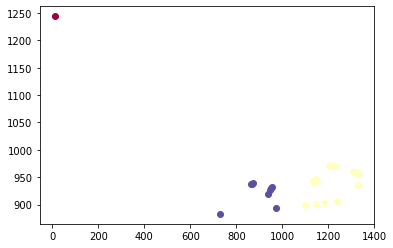

In [20]:


peak_x = []
peak_y = []
for i in range(3):
    for j in range(0, pf[i].shape[1], 5):
        p = pf[i][:,j]

        peaks, _ = find_peaks(p, prominence=50)
        if len(peaks) == 0:
            continue
        # first_peak = peaks[0]
        peak_y.append(peaks)
        peak_x.append([j]*len(peaks))



    data = [[item for sublist in peak_x for item in sublist ],
        [item for sublist in peak_y for item in sublist ]]

    clustering = GaussianMixture(n_components=5)
    X = np.array([[i,j] for i,j in zip(data[0], data[1])])
    labels = clustering.fit_predict(X)
    non_horizontal_labels = []
    for j in set(labels):
        xy = X[labels == j]
    # plt.ylim([0,pf[i].shape[0]])
    # plt.xlim([0,pf[i].shape[1]])
    # # plt.gca().invert_yaxis
    # plt.imshow(f[i], cmap='gray')
    # plt.show()
        
        if len(xy) > 5:
            slope, intercept, r_value, p_value, std_err = linregress(xy[:,0], xy[:,1])
            # plt.plot([0,1000],[intercept,intercept+1000*slope])
            # plt.xlim(0,2040)
            # plt.ylim(0,2040)
            # plt.imshow(f[i], cmap='gray')
            # plt.gca().invert_yaxis()
            # plt.show()
            if abs(slope) > 0.08:
                non_horizontal_labels.append(j)
    
    total_nb_peaks = 0
    for j in non_horizontal_labels:
        nb_peaks = X[labels == j].shape[0]
        total_nb_peaks += nb_peaks

    new_coord = np.zeros((total_nb_peaks,2))
    leftoff = 0
    for j in non_horizontal_labels:
        nb_peaks = X[labels == j].shape[0]
        new_coord[leftoff:leftoff+nb_peaks,:] = X[labels == j]
        leftoff += nb_peaks
    print('ok')
    # new_coord = X[labels != j for j in horizontal_labels]

    clustering = GaussianMixture(n_components=5)
    labels = clustering.fit_predict(new_coord)
    for j in set(labels):
        xy = new_coord[labels == j]
        # plt.ylim([0,pf[i].shape[0]])
        # plt.xlim([0,pf[i].shape[1]])
        # # plt.gca().invert_yaxis
        # plt.imshow(f[i], cmap='gray')
        # plt.show()
        
    for k in range(0,len(new_coord)):
        plt.plot(new_coord[k,0],new_coord[k,1],marker='o',c=cmap[labels[k]])

    plt.ylim([0,pf[i].shape[0]])
    plt.xlim([0,pf[i].shape[1]])
    plt.show()
        

        # if len(xy) > 5:
        #     slope, intercept, r_value, p_value, std_err = linregress(xy[:,0], xy[:,1])
        #     plt.plot([0,1000],[intercept,intercept+1000*slope])
        #     plt.xlim(0,2040)
        #     plt.ylim(0,2040)
        #     plt.imshow(f[i], cmap='gray')
        #     plt.gca().invert_yaxis()
        #     plt.show()

    

            

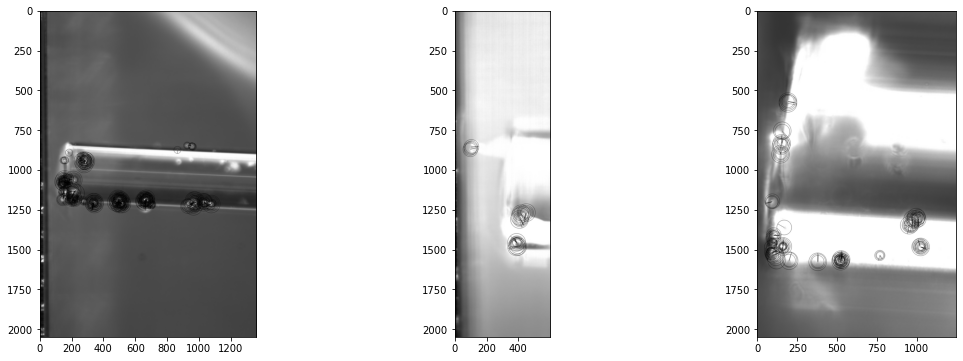

In [20]:


### Edge detections

feature_params = dict( maxCorners = 200,
                       qualityLevel = 0.2,
                       minDistance = 15,
                       blockSize = 9)
# Initiate ORB detector
orb = cv.ORB_create()

plt.figure(figsize=[18,6])
for i in range(0,3):
#     result = f[i].copy()
#     corners = cv.goodFeaturesToTrack(f[i], **feature_params)

#     corners = cv.cornerHarris(np.float32(f[i]), 2, 3, 0.04, cv.BORDER_DEFAULT)
#     if corners is not None:
#         for x, y in np.float32(corners).reshape(-1, 2):
#             cv.circle(result, (int(x),int(y)), 100, (0, 0, 0), 5)
   
    # find the keypoints with ORB
    kp = orb.detect(f[i],None)
    # compute the descriptors with ORB
    kp, des = orb.compute(f[i], kp)
    # draw only keypoints location,not size and orientation
    result = cv.drawKeypoints(f[i], kp, None, color=(0,0,0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.subplot(131+i)
    plt.imshow(result, cmap='gray')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


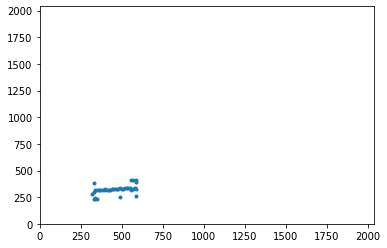

[array([320, 277], dtype=int64)]


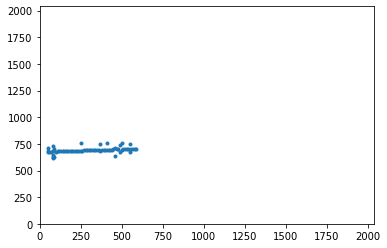

[array([320, 277], dtype=int64), array([ 50, 673], dtype=int64)]


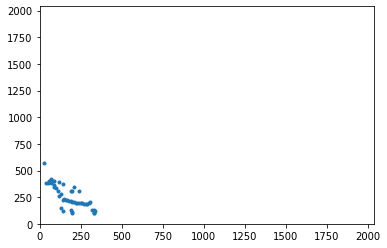

ValueError: too many values to unpack (expected 2)

In [21]:
### Copy from the py files: to try if the code works or not.

%load_ext autoreload
%autoreload
from img_separator import *
def get_array(file):
    return cv.imread(file)

def rescale(img, scale = 0.75):
    width = int (img.shape[1]*scale)
    height = int (img.shape[0]*scale)

    dimensions = (width,height)

    return cv.resize(img, dimensions, interpolation=cv.INTER_AREA)

def adapt_thresh_otsu(img):
    ret1, th1 = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    return th1

def get_contours_array(img):
    blank = np.zeros(img.shape, dtype = 'uint8')
    contours, hierarchies = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cv.drawContours(blank, contours, -1, (255,255,255), thickness=2)
    return blank

def get_text(img, text):
    imageText = img.copy()
    fontScale = 2.3
    fontFace = cv.FONT_HERSHEY_PLAIN
    fontColor = (255, 255, 255)
    fontThickness = 2

    cv.putText(imageText, text, (0, img.shape[0]), fontFace, fontScale, fontColor, fontThickness, cv.LINE_AA)
    return imageText

def background_profiler(img):
    ### Vertical profiling to calculate the background grayscale intensity.
    ### If the background is too bright (i.e. > 127), contrast_enhancer must be used.

    x = np.array(list(np.mean(img[j,:]) for j in range(0,img.shape[0])))
    peaks, _ = find_peaks(x, prominence=15)

    first_peak = peaks[0]
    last_peak = peaks[len(peaks)-1]
    
    ### margin of 50 pixels
    background= np.concatenate((img[:first_peak-50,:].ravel(),img[last_peak+50:,:].ravel()))
    return np.median(background)

def contrast_enhancer(img, gamma = 14):
    ### When gamma<1, the original dark regions will be brighter and he. histogram will be shifted to the right
    ### Whereas it will be the opposite with gamma>1.

    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    enhanced = cv.LUT(fiber, lookUpTable)
    return enhanced
### Segment the image

array = get_array('Photos/Photo_Fiber_Obj_50X.tif')
gray = cv.cvtColor(array, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray,(0,0),2)  ##box

img_left, img_right = img_separator (blur)
fiber = rescale(img_right, scale=0.48)

if background_profiler(fiber) >= 150:
    fiber = contrast_enhancer(fiber)

binary_fiber = adapt_thresh_otsu (fiber)
contour_fiber = get_contours_array(binary_fiber)
text, data = get_angle(contrast_enhancer(fiber), 'all', 'vertical', 10)

plt.figure(figsize=[18,6])
plt.subplot(121)
plt.imshow(binary_fiber, cmap='gray')
plt.subplot(122)
plt.imshow(get_text(contour_fiber, text), cmap='gray')


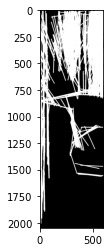

In [ ]:
### Line detection: doesn't work well

rho = 10  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 100  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 200  # minimum number of pixels making up a line
max_line_gap = 100  # maximum gap in pixels between connectable line segments
line_image = np.copy(cannys[1]) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv.HoughLinesP(cannys[1], rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(line_image,(x1,y1),(x2,y2),(255,255,255),5)

# Draw the lines on the  image
# lines_edges = cv.addWeighted(cannys[2], 0.8, line_image, 1, 0)
        
plt.imshow(line_image, cmap='gray')

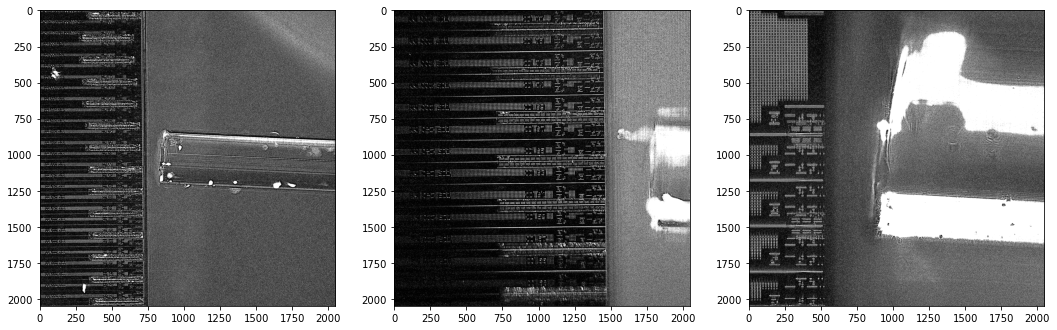

In [ ]:
### Sharpening, look good but create too much noise in the background
plt.figure(figsize=[18,6])
sharpens = []
for i in range(0,3):
    sharpens.append(unsharp_mask(grays[i]))
    plt.subplot(131+i)
    plt.imshow(sharpens[i], cmap='gray')

Old codes on MOSFET image

(-5.0, 260.0)

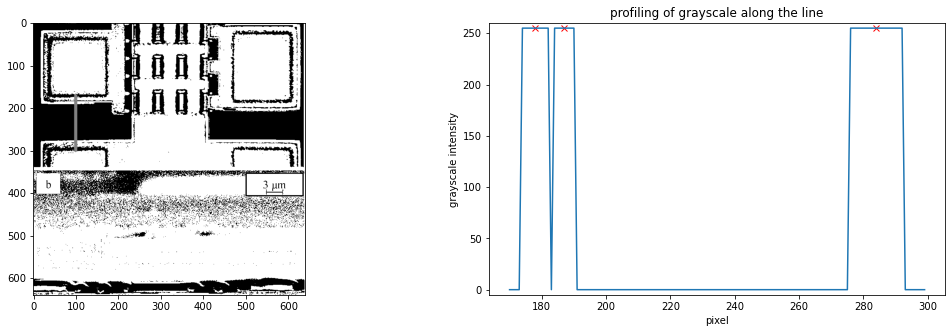

In [ ]:
imageLine3 = gray_thresh_gbl.copy()

# The line starts from (200,100) and ends at (400,100)
# The color of the line is YELLOW (Recall that OpenCV uses BGR format)
# Thickness of line is 5px
# Linetype is cv2.LINE_AA

cv.line(imageLine3, (100, 170), (100, 300), (130, 130, 130), thickness=5, lineType=cv.LINE_AA);

plt.figure(figsize=[18,5])
# Display the image
plt.subplot(121); plt.imshow(imageLine3, cmap='gray')
#profiling
plt.subplot(122)
peaks3, properties3 = find_peaks(gray_thresh_gbl[170:300,100], prominence=3)
plt.plot(170+peaks3, gray_thresh_gbl[170:300,100][peaks3], "x", c="red")
plt.plot(range(170,300), gray_thresh_gbl[170:300,100])
# plt.axvline(x=189, c='green', ls='--')
# plt.axvline(x=278, c='green', ls='--')
plt.title('profiling of grayscale along the line')
plt.ylabel('grayscale intensity')
plt.xlabel('pixel')
plt.ylim([-5,260])

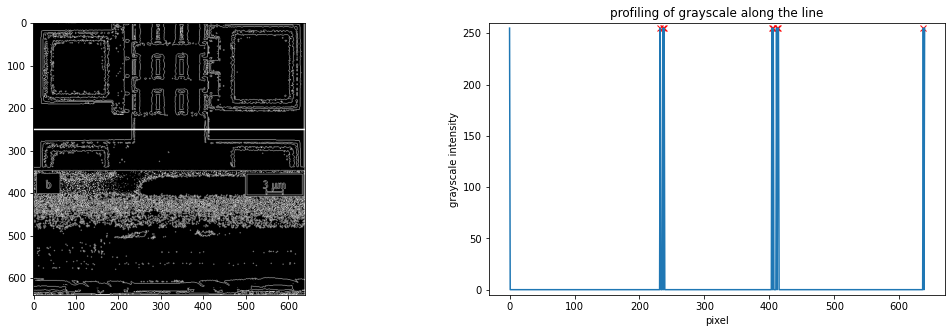

In [ ]:
blank = np.zeros(gray.shape[:2], dtype = 'uint8')
contours, hierarchies = cv.findContours(gray_thresh_gbl, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(blank, contours, -1, (255,255,255), 1)
plt.figure(figsize=[18,5])
# Display the image
imageLine4 = blank.copy()
cv.line(imageLine4, (0, 250), (640, 250), (255, 255, 255), thickness=2, lineType=cv.LINE_AA)
plt.subplot(121); plt.imshow(imageLine4, cmap='gray')
#profiling
plt.subplot(122)
peaks4, properties4 = find_peaks(blank[250,0:640], prominence=3)
plt.plot(peaks4, blank[250,0:640][peaks4], "x", c="red")
plt.plot(range(0,640), blank[250,0:640])
# plt.axvline(x=189, c='green', ls='--')
# plt.axvline(x=278, c='green', ls='--')
plt.title('profiling of grayscale along the line')
plt.ylabel('grayscale intensity')
plt.xlabel('pixel')
plt.ylim([-5,260])
plt.show()

(-5.0, 260.0)

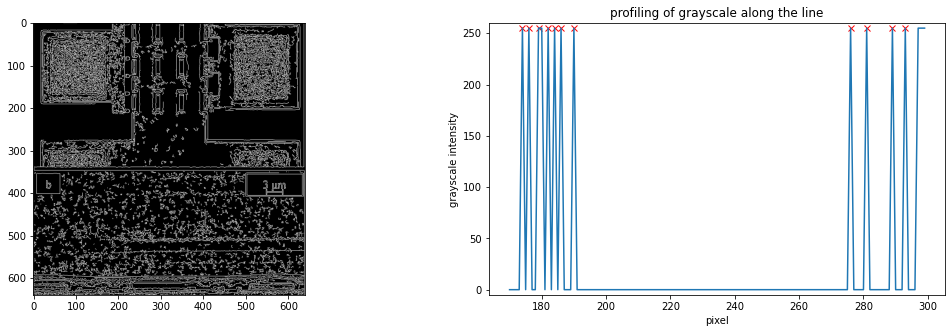

In [ ]:
canny = cv.Canny(gray, 50, 100)
plt.figure(figsize=[18,5])
# Display the image
plt.subplot(121); plt.imshow(canny, cmap='gray')
#profiling
plt.subplot(122)
peaks5, properties5 = find_peaks(canny[170:300,100], prominence=1)
plt.plot(170+peaks5, canny[170:300,100][peaks5], "x", c="red")
plt.plot(range(170,300), canny[170:300,100])
plt.title('profiling of grayscale along the line')
plt.ylabel('grayscale intensity')
plt.xlabel('pixel')
plt.ylim([-5,260])